# Predicting COVID-19 cases

The "Hospital Israelita Albert Einstein", São Paulo/Brazil, recently released a [dataset of >5k patients that were tested for the COVID-19](https://www.kaggle.com/dataset/e626783d4672f182e7870b1bbe75fae66bdfb232289da0a61f08c2ceb01cab01/version/7#).

They are asking data scientists to:

* T1: Predict confirmed COVID-19 cases among suspected cases.
* T2: Predict admission to general ward, semi-intensive unit or intensive care unit among confirmed COVID-19 cases.

This is my personal exploration of the problem. Feel free to contact me with suggestions! 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel("dataset.xlsx")

## Data preparation

We first need to understand what the dataset looks like. This is even more challenging, because I am not a medical doctor.

Let us just see how many instances of positive and negative data points we have:

In [3]:
df.groupby("SARS-Cov-2 exam result").count()

,Patient ID,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
SARS-Cov-2 exam result,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
negative,5086,5086,5086,5086,5086,520,520,519,518,519,519,519,519,519,519,519,519,518,519,175,1242,1242,1242,1240,1240,1240,0,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,438,338,436,362,313,312,758,758,185,186,123,142,142,142,115,44,318,35,116,116,116,116,1,116,116,116,88,88,88,88,88,88,49,58,58,58,58,48,1,58,57,50,0,58,58,58,56,57,58,58,0,76,110,75,0,3,81,21,14,5,0,13,14,14,14,14,14,14,14,11,19,14
positive,558,558,558,558,558,83,83,83,81,83,83,83,83,83,83,83,83,83,83,33,112,112,112,112,112,112,0,112,112,112,112,112,112,112,112,112,112,112,75,59,70,62,58,58,62,62,40,40,30,40,40,40,29,6,14,5,20,20,20,20,0,20,20,20,9,9,9,9,9,9,11,12,12,12,12,9,0,12,12,10,0,12,12,12,11,12,12,12,0,15,23,26,0,0,23,2,13,3,0,0,13,13,13,13,13,13,13,9,1,13


**Observation: The dataset is a bit imbalanced, as 9% positive, 91% negative** 

Let's explore the values in the dataset, and see what types of values we see in each column, or what types of exceptions there are.

(code below is commented, because it generates a huge block of text. Uncomment if you want to manually see all the values)

In [4]:
#for column in df.columns:
#    print(column)
#    print(df[column].unique())

Ok. We observe that:

* Some columns do not give clinical information about the patient
* Some other columns either have NAs or 0, which don't help any model
* Others are categorical and need some encoding
* Lots of NAs

In [5]:
# Let's drop columns that do not give clinical information about the patient
no_information = [
    "Patient ID", 
    "Patient addmited to regular ward (1=yes, 0=no)", 
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)"]
df = df.drop(no_information, axis=1)

In [6]:
# Let's drop features that, for some reason, are empty or only contain empty data points
features_to_drop = [
    "Mycoplasma pneumoniae", # it is always NA
    "Fio2 (venous blood gas analysis)", # NA or 0
    "Myeloblasts", # NA or 0
    "Urine - Nitrite", # absent or not done
    "Urine - Urobilinogen", # nan, normal, not done
    "Urine - Protein", # nan, normal, not done
    "Urine - Sugar", # na
    "Urine - Hyaline cylinders", # na or absent,
    "Urine - Granular cylinders", # na or absent,
    "Urine - Yeasts", # na absent
    "Partial thromboplastin time (PTT) ", # nan
    "Prothrombin time (PT), Activity", # nan
    "D-Dimer", # nan
]
df = df.drop(features_to_drop, axis=1)

In [7]:
# some columns need encoding
columns_that_need_encoding = [
    "Respiratory Syncytial Virus",
    "Influenza A",
    "Influenza B",
    "Parainfluenza 1",
    "CoronavirusNL63",
    "Rhinovirus/Enterovirus",
    "Coronavirus HKU1",
    "Parainfluenza 3",
    "Chlamydophila pneumoniae",
    "Adenovirus",
    "Parainfluenza 4",
    "Coronavirus229E",
    "CoronavirusOC43",
    "Inf A H1N1 2009",
    "Bordetella pertussis",
    "Metapneumovirus",
    "Parainfluenza 2",
    "Influenza B, rapid test",
    "Influenza A, rapid test",
    "Strepto A",
    "Urine - Esterase",
    "Urine - Aspect",
    "Urine - Hemoglobin",
    "Urine - Bile pigments",
    "Urine - Ketone Bodies",
    "Urine - Crystals",
    "Urine - Color",
]

# some columns have value written in PT-BR
df["Urine - Crystals"].replace("Ausentes", "absent", inplace=True)
# TODO: I do not know how to translate the following: Urato Amorfo and Oxalato de Cálcio

# Let's get the names of numerical columns, before we change the categorical ones
#numerical_columns = list(df.columns)
#for column in columns_that_need_encoding:
#    numerical_columns.remove(column)
#numerical_columns.remove("SARS-Cov-2 exam result")

# Get the dummies
for column in columns_that_need_encoding:
    df[column].replace(float('NaN'), "RESULT ABSENT", inplace=True)
    df = pd.get_dummies(df, columns=[column],prefix_sep='_')
    
# leave only the dummies about the positive values
df = df.drop([column for column in list(df.columns) 
 if ("_not_done" in column) or
 ("_RESULT ABSENT" in column) or
 ("_not_detected" in column) or
  ("_absent" in column) or
 ("_negative" in column)], axis=1)

In [8]:
# Replace "Não realizado" by NaN
df["Urine - pH"].replace("Não Realizado", np.nan, inplace=True)
df['Urine - pH'] = df['Urine - pH'].astype("float64")

# Replace this strange <1000 to 999
df["Urine - Leukocytes"].replace("<1000", 999, inplace=True)
df['Urine - Leukocytes'] = df['Urine - pH'].astype("float64")

In [9]:
# predicted label as simple integers
df["SARS-Cov-2 exam result"].replace("positive", 1, inplace=True)
df["SARS-Cov-2 exam result"].replace("negative", 0, inplace=True)

An important question is what to do with the high amount of NAs. My first attempt will be to make it -9999, a number very different from the rest, so that the model will hopefully learn what it means.

In [10]:
# we should see lots of falses
print((df.isnull().sum() == 0).value_counts())
df_with_na = df

# what to do with NAs?
df = df.fillna(0)

# we should only see trues now
print((df.isnull().sum() == 0).value_counts())

False    65
True     34
dtype: int64
True    99
dtype: int64


What does it look like now?

The model has the following features (minus the "SARS-Cov-2 exam result"):

In [11]:
print(len(list(df.columns)))
print(list(df.columns))

99
['Patient age quantile', 'SARS-Cov-2 exam result', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Serum Glucose', 'Neutrophils', 'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bilirubin', 'Direct Bilirubin', 'Indirect Bilirubin', 'Alkaline phosphatase', 'Ionized calcium\xa0', 'Magnesium', 'pCO2 (venous blood gas analysis)', 'Hb saturation (venous blood gas analysis)', 'Base excess (venous blood gas analysis)', 'pO2 (venous blood gas analysis)', 'Total CO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)', 'HCO3 (venous blood gas analysis)', 'Rods #', 'Segmented', 'Promyelocytes', 'Met

In [12]:
# saving it to an CSV
df.to_csv("dataset-clean.csv")

Dataset is clean. And saved to a new dataset-clean.xlsx Excel file.

## Building models

It is time to make some experiments. See which models can model the problem.

Some functions below just to help us on the job:
* Extract feature importances, as we want to know what helps the model in predicting
* Run CV, maybe more interesting at the end once we have a model that seems promising
* Run, train and test the model

In [13]:
def _extract_feature_importance(model, features):
    if not hasattr(model, "coef_") and not hasattr(model, "feature_importances_"):
        raise Exception("Not possible to collect feature importances")

    if hasattr(model, "coef_"):
        model_feature_importances = model.coef_[0]
    elif hasattr(model, "feature_importances_"):
        model_feature_importances = model.feature_importances_

    return [
        (feature, importance)
        for feature, importance in sorted(
            zip(features, model_feature_importances),
            key=lambda pair: pair[1],
            reverse=True,
        )
    ]

# def run_cv(X_train, y_train, X_test, y_test, which_model=RandomForestClassifier(random_state=42), optimize_for="roc_auc"):

#     K_FOLD_ITERATIONS = 5

#     params_to_tune = {
#         "max_depth": [3, 6, 12, 24, None],
#       "max_features": ["auto", "sqrt", "log2", None],
#       "min_samples_split": [2, 3, 4, 5, 10],
#       "bootstrap": [True, False],
#       "criterion": ["gini", "entropy"],
#       "n_estimators": [10, 50, 100, 150, 200]}

#     search = GridSearchCV(
#         which_model, 
#         params_to_tune, 
#         scoring=["precision", "recall", "roc_auc"],
#         refit=optimize_for,
#         cv=StratifiedKFold(
#             n_splits=K_FOLD_ITERATIONS, 
#             shuffle=True),  
#         n_jobs=-1)
    
#     search.fit(X_train, y_train)
    
#     model = search.best_estimator_

#     predictions = model.predict(X_test)

#     idx = search.best_index_
#     scores_cv = pd.DataFrame(search.cv_results_).iloc[idx]
#     metrics = {"prec": "test_precision", "rec": "test_recall", "roc": "test_roc_auc"}
#     cv_results = {
#         k: (scores_cv["mean_" + v], scores_cv["std_" + v]) for k, v in metrics.items()
#     }
#     test_results = {
#         "prec": precision_score(y_test, predictions),
#         "rec": recall_score(y_test, predictions),
#         "roc": roc_auc_score(y_test, predictions),
#     }

#     cm = confusion_matrix(y_test, predictions)
    
#     feature_importance = _extract_feature_importance(model, X_train.columns.values)
#     return search, model, cv_results, test_results, cm, feature_importance
    
    
def run_single(X_train, y_train, X_test, y_test, model=RandomForestClassifier(random_state=42)):

    model.fit(X_train, y_train)
    
    # let us just print the performance on the train set
    predictions = model.predict(X_train)
    train_results = {
        "prec": precision_score(y_train, predictions),
        "rec": recall_score(y_train, predictions),
        "roc": roc_auc_score(y_train, predictions),
    }
    cm_train = confusion_matrix(y_train, predictions)

    # now, let's predict in the test set
    predictions = model.predict(X_test)

    test_results = {
        "prec": precision_score(y_test, predictions),
        "rec": recall_score(y_test, predictions),
        "roc": roc_auc_score(y_test, predictions),
    }

    cm_test = confusion_matrix(y_test, predictions)
    
    feature_importance = _extract_feature_importance(model, X_train.columns.values)
    return {
        "model": model, 
        "cm_train": cm_train, 
        "train_results" : train_results, 
        "cm_test" : cm_test, 
        "test_results" : test_results,
        "feature_importance" : feature_importance,
        "y_true": y_test,
        "y_pred": predictions
    }

from sklearn.metrics import classification_report

def print_result(result, fi=True):
    print("Results in the training set")
    print(result["train_results"])
    print(result["cm_train"])
    print("Results in the test set")
    print(result["test_results"])
    print(result["cm_test"])
    
    print("Report:")
    print(classification_report(result["y_true"],result["y_pred"]))
    
    if fi:
        print("Feature importances")
        pd_fi = pd.DataFrame(result["feature_importance"], columns=["feature", "importance"])
        pd_fi = pd_fi[(pd_fi.importance > 0.01)]

        p = plt.barh(pd_fi["feature"], pd_fi["importance"])
        print(p)    

### Experiment 1: All the features

In The first batch of experiments, we will try to use all the set of features, and let the model figure out what's good and what's not.

`X` contains all features, `y` contains the predicted value.

In [14]:
X = df.drop("SARS-Cov-2 exam result", axis=1)
y = df["SARS-Cov-2 exam result"]

Let's split in test and train. 20% for testing. We do it in a stratified way, keeping the proportions (~91%-9%)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

0    4065
1     450
Name: SARS-Cov-2 exam result, dtype: int64
0    1021
1     108
Name: SARS-Cov-2 exam result, dtype: int64


This means we have: 
* 4515 data points for training (where 450 of them are positive patients), and
* 1129 data points for testing (where 108 are positive).

### Experimenting 1.1: Imbalancing data

Data is highly imbalanced as we saw. Let us see if the model can overcome that:

Results in the training set
{'prec': 1.0, 'rec': 0.16, 'roc': 0.58}
[[4065    0]
 [ 378   72]]
Results in the test set
{'prec': 0.8571428571428571, 'rec': 0.05555555555555555, 'roc': 0.5272880618130373}
[[1020    1]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.86      0.06      0.10       108

    accuracy                           0.91      1129
   macro avg       0.88      0.53      0.53      1129
weighted avg       0.90      0.91      0.87      1129

Feature importances
<BarContainer object of 24 artists>


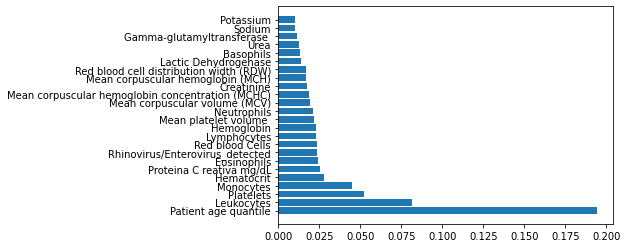

In [16]:
result = run_single(X_train, y_train, X_test, y_test,RandomForestClassifier(random_state=42))
print_result(result)

**Observation:** A simple Random Forrest has a **poor (but somewhat interesting) performance**. The model seems to never predict 'true's. However, in the rare moments it does, it achieves a precision of 83% (5 out of 6). However, given that we had 108 true data points to be predicted, this means the model only finds <5% of them (and that's why such a low recall).

### Experiment 1.2: Balancing training via oversampling

Maybe the model needs more data from the undersampled class. Let's then generate some extra training data points by means of techniques such as SMOTE.

In [17]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)

Results in the training set
{'prec': 0.6214812332439679, 'rec': 0.9124231242312423, 'roc': 0.6783517835178352}
[[1806 2259]
 [ 356 3709]]
Results in the test set
{'prec': 0.12363067292644757, 'rec': 0.7314814814814815, 'roc': 0.5914998004860885}
[[461 560]
 [ 29  79]]
Report:
              precision    recall  f1-score   support

           0       0.94      0.45      0.61      1021
           1       0.12      0.73      0.21       108

    accuracy                           0.48      1129
   macro avg       0.53      0.59      0.41      1129
weighted avg       0.86      0.48      0.57      1129

Feature importances
<BarContainer object of 19 artists>


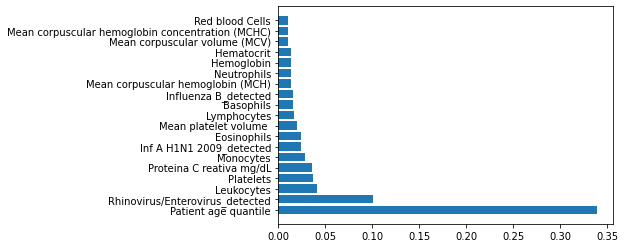

In [18]:
result = run_single(X_resampled, y_resampled, X_test, y_test,RandomForestClassifier(random_state=42))
print_result(result)

**Observation:** This model seems to do the inverse of the previous model. It predicts more 'true's than the previous model (641 trues), but it is correct only in 12.6% of the cases. Too many false positives. Thus, over sampling does not seem to help. 

### Experiment 1.3: Balancing training, undersampling

Let us try another way of balancing the dataset. Undersampling. The amount of data is too small, and I don't expect great results here, but let's test it empirically:

In [19]:
from imblearn.under_sampling import RandomUnderSampler

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)

Results in the training set
{'prec': 0.6296296296296297, 'rec': 0.9444444444444444, 'roc': 0.6944444444444444}
[[200 250]
 [ 25 425]]
Results in the test set
{'prec': 0.12569060773480664, 'rec': 0.8425925925925926, 'roc': 0.6113060906155912}
[[388 633]
 [ 17  91]]
Report:
              precision    recall  f1-score   support

           0       0.96      0.38      0.54      1021
           1       0.13      0.84      0.22       108

    accuracy                           0.42      1129
   macro avg       0.54      0.61      0.38      1129
weighted avg       0.88      0.42      0.51      1129

Feature importances
<BarContainer object of 21 artists>


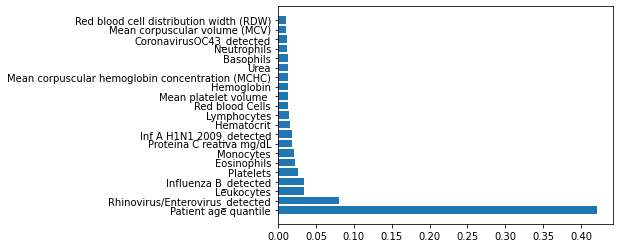

In [20]:
result = run_single(X_resampled, y_resampled, X_test, y_test,RandomForestClassifier(random_state=42))
print_result(result)

**Observation**: Similar results. While a better recall, precision is really low (12.5%). So, it seems that under/over sampling only is not enough.

### Experiment 2: Handling NaNs differently

Too many NaNs. In the previous batch, we replaced it by -9999. Let's see if a different strategy holds better results.

In [21]:
from sklearn.impute import SimpleImputer

# thanks to https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera
fill_NaN = SimpleImputer(missing_values=-9999, strategy='median')

imputed_train = pd.DataFrame(fill_NaN.fit_transform(X_train))
imputed_train.columns = X_train.columns
imputed_train.index = X_train.index

imputed_test = pd.DataFrame(fill_NaN.fit_transform(X_test))
imputed_test.columns = X_test.columns
imputed_test.index = X_test.index

### Experiment 2.1: Imputing median in NaN, imbalanced data

Results in the training set
{'prec': 1.0, 'rec': 0.16, 'roc': 0.58}
[[4065    0]
 [ 378   72]]
Results in the test set
{'prec': 0.8571428571428571, 'rec': 0.05555555555555555, 'roc': 0.5272880618130373}
[[1020    1]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.86      0.06      0.10       108

    accuracy                           0.91      1129
   macro avg       0.88      0.53      0.53      1129
weighted avg       0.90      0.91      0.87      1129

Feature importances
<BarContainer object of 24 artists>


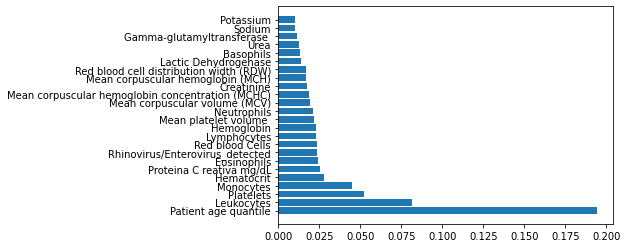

In [22]:
result = run_single(imputed_train, y_train, imputed_test, y_test,RandomForestClassifier(random_state=42))
print_result(result)

### Experiment 2.2: Imputing median in NaN, balancing via SMOTE

Results in the training set
{'prec': 0.6240013315579228, 'rec': 0.9222632226322264, 'roc': 0.6832718327183271}
[[1806 2259]
 [ 316 3749]]
Results in the test set
{'prec': 0.12363067292644757, 'rec': 0.7314814814814815, 'roc': 0.5914998004860885}
[[461 560]
 [ 29  79]]
Report:
              precision    recall  f1-score   support

           0       0.94      0.45      0.61      1021
           1       0.12      0.73      0.21       108

    accuracy                           0.48      1129
   macro avg       0.53      0.59      0.41      1129
weighted avg       0.86      0.48      0.57      1129

Feature importances
<BarContainer object of 19 artists>


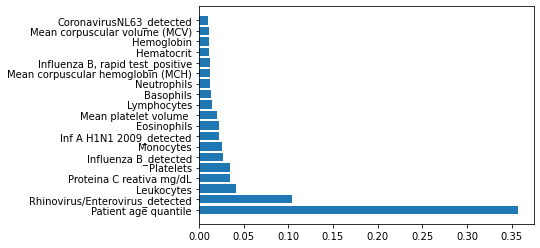

In [23]:
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(imputed_train, y_train)
X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)

result = run_single(X_resampled, y_resampled, imputed_test, y_test,RandomForestClassifier(random_state=42))
print_result(result)

**Observation**: Replacing NaNs by 'median' does not seem to help. If all, the precision dropped from 83% to 66% (experiments 1 and 2, without balancing).

(We have also tried with 'mean' instead of 'median', but no difference)

### Experiment 3: Trying different classifiers

Maybe Random Forest is not the best classifier for the problem?

In [24]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

classifiers_to_try = [
    RandomForestClassifier(n_estimators=300, random_state=42),
    AdaBoostClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(random_state=42),
    SGDClassifier(random_state=42),
    ExtraTreesClassifier(n_estimators=100, random_state=42)
]

In [25]:
def try_all_classifiers(X_train, y_train, X_test, y_test):
    for classifier in classifiers_to_try:
        print("*********")
        print(classifier)
        result = run_single(X_train, y_train, X_test, y_test,classifier)
        print_result(result, fi=False)

### Experiment 3.1: Different classifiers, NaN=-9999

In [26]:
try_all_classifiers(X_train, y_train, X_test, y_test)

*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Results in the training set
{'prec': 1.0, 'rec': 0.16, 'roc': 0.58}
[[4065    0]
 [ 378   72]]
Results in the test set
{'prec': 0.8571428571428571, 'rec': 0.05555555555555555, 'roc': 0.5272880618130373}
[[1020    1]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.86      0.06      0.10       108

    accuracy                           0.91

### Experiment 3.2: Different classifiers, NaN=median

In [27]:
try_all_classifiers(imputed_train, y_train, imputed_test, y_test)

*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Results in the training set
{'prec': 1.0, 'rec': 0.16, 'roc': 0.58}
[[4065    0]
 [ 378   72]]
Results in the test set
{'prec': 0.8571428571428571, 'rec': 0.05555555555555555, 'roc': 0.5272880618130373}
[[1020    1]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.86      0.06      0.10       108

    accuracy                           0.91

### Experiment 3.3: Different classifiers, NaN=median, oversampling

In [28]:
try_all_classifiers(X_resampled, y_resampled, imputed_test, y_test)

*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Results in the training set
{'prec': 0.6240013315579228, 'rec': 0.9222632226322264, 'roc': 0.6832718327183271}
[[1806 2259]
 [ 316 3749]]
Results in the test set
{'prec': 0.125, 'rec': 0.7407407407407407, 'roc': 0.5961294301157181}
[[461 560]
 [ 28  80]]
Report:
              precision    recall  f1-score   support

           0       0.94      0.45      0.61      1021
           1       0.12      0.74      0.21       108

    accuracy      

**Observation**: All the classifiers we tried behaved poorly (ok precision, but very low recall). It doesn't matter how we handle NaNs or balance the data.

### Experiment 4: Scaling features

I do not think the scale of the features can influence, but, why not try?

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# let us fit in the entire dataset
# but the one not with -9999, as that can change how the scale will behave
# let's impute medians first
X_imputed = pd.DataFrame(fill_NaN.fit_transform(X))
scaler.fit(X_imputed)

x_train_transformed = scaler.transform(imputed_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=X_train.columns)
x_test_transformed = scaler.transform(imputed_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=X_train.columns)

In [30]:
x_train_transformed.describe()

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Urine - pH,Urine - Density,Urine - Leukocytes,Urine - Red blood cells,Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis),Respiratory Syncytial Virus_detected,Influenza A_detected,Influenza B_detected,Parainfluenza 1_detected,CoronavirusNL63_detected,Rhinovirus/Enterovirus_detected,Coronavirus HKU1_detected,Parainfluenza 3_detected,Chlamydophila pneumoniae_detected,Adenovirus_detected,Parainfluenza 4_detected,Coronavirus229E_detected,CoronavirusOC43_detected,Inf A H1N1 2009_detected,Bordetella pertussis_detected,Metapneumovirus_detected,"Influenza B, rapid test_positive","Influenza A, rapid test_positive",Strepto A_positive,Urine - Aspect_altered_coloring,Urine - Aspect_clear,Urine - Aspect_cloudy,Urine - Aspect_lightly_cloudy,Urine - Hemoglobin_present,Urine - Crystals_Oxalato de Cálcio +++,Urine - Crystals_Oxalato de Cálcio -++,Urine - Crystals_Urato Amorfo +++,Urine - Crystals_Urato Amorfo --+,Urine - Color_citrus_yellow,Urine - Color_light_yellow,Urine - Color_orange,Urine - Color_yellow
count,4515.000000,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4515.000000,4.515000e+03,4515.000000,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4.515000e+03,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000,4515.000000
mean,0.002586,-2.393623e-03,-1.273539e-03,-6.919341e-03,8.630795e-03,-4.918329e-03,7.829809e-04,3.041568e-03,-4.006889e-03,5.850859e-03,5.140333e-03,5.753499e-04,4.276139e-03,9.757651e-03,2.198044e-03,1.985874e-03,5.280011e-03,-7.002743e-03,4.431442e-04,-1.252857e-03,-3.073818e-03,5.284909e-03,-5.875573e-03,-9.421938e-05,-1.004925e-02,6.471882e-04,-3.474390e-03,3.974115e-03,-6.531114e-03,-6.255136e-04,-8.235254e-03,2.412195e-03,5.862285e-05,-4

Results in the training set
{'prec': 1.0, 'rec': 0.16, 'roc': 0.58}
[[4065    0]
 [ 378   72]]
Results in the test set
{'prec': 0.8571428571428571, 'rec': 0.05555555555555555, 'roc': 0.5272880618130373}
[[1020    1]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.86      0.06      0.10       108

    accuracy                           0.91      1129
   macro avg       0.88      0.53      0.53      1129
weighted avg       0.90      0.91      0.87      1129

Feature importances
<BarContainer object of 24 artists>


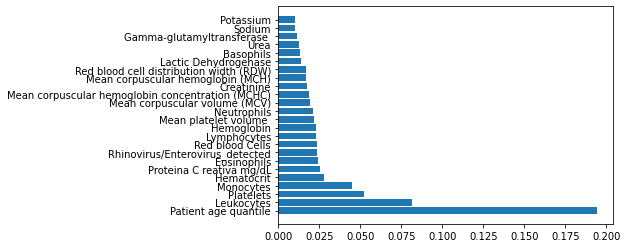

In [31]:
result = run_single(x_train_transformed, y_train, x_test_transformed, y_test,RandomForestClassifier(random_state=42))
print_result(result)

In [32]:
try_all_classifiers(x_train_transformed, y_train, x_test_transformed, y_test)

*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Results in the training set
{'prec': 1.0, 'rec': 0.16, 'roc': 0.58}
[[4065    0]
 [ 378   72]]
Results in the test set
{'prec': 0.8571428571428571, 'rec': 0.05555555555555555, 'roc': 0.5272880618130373}
[[1020    1]
 [ 102    6]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.86      0.06      0.10       108

    accuracy                           0.91

**Observation:** Scaling seems not to make a difference.

### Experiment 5: Feature selection

Maybe too much noise in the dataset? Too many columns with NAs.

Let's count the number of NAs per column

In [33]:
nas = pd.DataFrame(df_with_na.isna().sum(), columns=["nas"])
nas["pct"] = nas["nas"] / df_with_na.shape[0]

In [34]:
nas

,nas,pct
Patient age quantile,0,0.000000
SARS-Cov-2 exam result,0,0.000000
Hematocrit,5041,0.893161
Hemoglobin,5041,0.893161
Platelets,5042,0.893338
...,...,...
Urine - Crystals_Urato Amorfo --+,0,0.000000
Urine - Color_citrus_yellow,0,0.000000
Urine - Color_light_yellow,0,0.000000
Urine - Color_orange,0,0.000000


Indeed, many NAs. Let's see how many columns have a NA, per percentage:

In [35]:
for i in np.arange(50, 100):
    pct = nas[nas["pct"] <= (i/100)].shape[0]
    print(f"<{i}% NAs={pct} features")

<50% NAs=34 features
<51% NAs=34 features
<52% NAs=34 features
<53% NAs=34 features
<54% NAs=34 features
<55% NAs=34 features
<56% NAs=34 features
<57% NAs=34 features
<58% NAs=34 features
<59% NAs=34 features
<60% NAs=34 features
<61% NAs=34 features
<62% NAs=34 features
<63% NAs=34 features
<64% NAs=34 features
<65% NAs=34 features
<66% NAs=34 features
<67% NAs=34 features
<68% NAs=34 features
<69% NAs=34 features
<70% NAs=34 features
<71% NAs=34 features
<72% NAs=34 features
<73% NAs=34 features
<74% NAs=34 features
<75% NAs=34 features
<76% NAs=34 features
<77% NAs=34 features
<78% NAs=34 features
<79% NAs=34 features
<80% NAs=34 features
<81% NAs=34 features
<82% NAs=34 features
<83% NAs=34 features
<84% NAs=34 features
<85% NAs=34 features
<86% NAs=34 features
<87% NAs=34 features
<88% NAs=34 features
<89% NAs=34 features
<90% NAs=48 features
<91% NAs=49 features
<92% NAs=50 features
<93% NAs=52 features
<94% NAs=54 features
<95% NAs=54 features
<96% NAs=55 features
<97% NAs=60 f

Indeed, the amount of NAs is really significant. I should have seen it in such detail before. 

The 34 ones we see there are basically the categorical features, but in the transformation, we "threw away" the NAs when we decided to keep only the "detected" columns.

### Experiment 5.1: Automated feature selection, NA=-9999

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

selector = SelectFromModel(estimator=DecisionTreeClassifier(random_state=42)).fit(X, y)

feature_idx = selector.get_support()
feature_name = X.columns[feature_idx]

X_train_selected_ones = selector.transform(X_train)
X_train_selected_ones = pd.DataFrame(X_train_selected_ones, columns=feature_name)

X_test_selected_ones = selector.transform(X_test)
X_test_selected_ones = pd.DataFrame(X_test_selected_ones, columns=feature_name)

print(feature_name)

Index(['Patient age quantile', 'Hematocrit', 'Platelets',
       'Mean platelet volume ', 'Lymphocytes', 'Leukocytes', 'Basophils',
       'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Proteina C reativa mg/dL', 'Aspartate transaminase',
       'Ionized calcium ', 'Urine - Red blood cells', 'Lactic Dehydrogenase',
       'pCO2 (arterial blood gas analysis)', 'Influenza B_detected',
       'Rhinovirus/Enterovirus_detected', 'Influenza B, rapid test_positive'],
      dtype='object')


In [37]:
try_all_classifiers(X_train_selected_ones, y_train, X_test_selected_ones, y_test)

*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Results in the training set
{'prec': 1.0, 'rec': 0.15333333333333332, 'roc': 0.5766666666666667}
[[4065    0]
 [ 381   69]]
Results in the test set
{'prec': 0.9, 'rec': 0.08333333333333333, 'roc': 0.5411769507019262}
[[1020    1]
 [  99    9]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.90      0.08      0.15       108

    accuracy                 

### Exercise 5.2: Automated feature selection, NaN=median

In [38]:
fill_NaN = SimpleImputer(missing_values=-9999, strategy='median')

imputed_X = pd.DataFrame(fill_NaN.fit_transform(X))
imputed_X.columns = X.columns
imputed_X.index = X.index

selector = SelectFromModel(estimator=DecisionTreeClassifier(random_state=42)).fit(imputed_X, y)

feature_idx = selector.get_support()
feature_name = X.columns[feature_idx]

X_train_selected_ones = selector.transform(imputed_train)
X_train_selected_ones = pd.DataFrame(X_train_selected_ones, columns=feature_name)

X_test_selected_ones = selector.transform(imputed_test)
X_test_selected_ones = pd.DataFrame(X_test_selected_ones, columns=feature_name)

print(feature_name)

Index(['Patient age quantile', 'Hematocrit', 'Platelets',
       'Mean platelet volume ', 'Lymphocytes', 'Leukocytes', 'Basophils',
       'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Proteina C reativa mg/dL', 'Aspartate transaminase',
       'Ionized calcium ', 'Urine - Red blood cells', 'Lactic Dehydrogenase',
       'pCO2 (arterial blood gas analysis)', 'Influenza B_detected',
       'Rhinovirus/Enterovirus_detected', 'Influenza B, rapid test_positive'],
      dtype='object')


In [39]:
try_all_classifiers(X_train_selected_ones, y_train, X_test_selected_ones, y_test)

*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Results in the training set
{'prec': 1.0, 'rec': 0.15333333333333332, 'roc': 0.5766666666666667}
[[4065    0]
 [ 381   69]]
Results in the test set
{'prec': 0.9, 'rec': 0.08333333333333333, 'roc': 0.5411769507019262}
[[1020    1]
 [  99    9]]
Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1021
           1       0.90      0.08      0.15       108

    accuracy                 

**Observation:** Feature reduction does not really help the model.

### Experiment 6. Clustering

Let us try and see if clustering algorithms can work well.

### Experiment 7. Deep learning

Maybe we need some deep learning?

### Experiment 8. LGBM Classifier

In [this notebook](https://www.kaggle.com/rodrigonanosys/covid19-task1-gini-63-rocauc-81-acc-92), the author seems to achieve a nice result. I'll try to use the same model.

Results in the training set
{'prec': 0.13466958972752896, 'rec': 0.9555555555555556, 'roc': 0.6379253792537926}
[[1302 2763]
 [  20  430]]
Results in the test set
{'prec': 0.12244897959183673, 'rec': 0.8888888888888888, 'roc': 0.6075198607030144}
[[333 688]
 [ 12  96]]
Report:
              precision    recall  f1-score   support

           0       0.97      0.33      0.49      1021
           1       0.12      0.89      0.22       108

    accuracy                           0.38      1129
   macro avg       0.54      0.61      0.35      1129
weighted avg       0.88      0.38      0.46      1129

Feature importances
<BarContainer object of 15 artists>


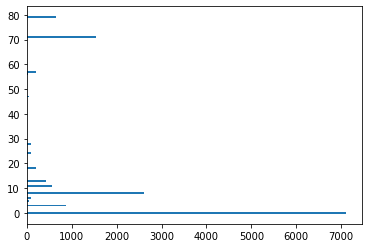

In [52]:
model = LGBMClassifier(boosting_type='gbdt',
                        num_leaves=10,
                        max_depth=1,
                        learning_rate=0.05,
                        n_estimators=200,
                        subsample_for_bin=200000,
                        objective='binary',
                        class_weight=None,
                        is_unbalance = True,
                        min_split_gain=1,
                        min_child_weight=0.0001,
                        min_child_samples=1,
                        subsample=1.0, 
                        subsample_freq=0,
                        colsample_bytree=1.0, 
                        reg_alpha=0.0,
                        reg_lambda=0.0, 
                        random_state=37,
                        n_jobs=3,
                        silent=True,
                        importance_type='gain'
                        )

# renaming all columns because the model seems to struggle with columns names...
Xtrain_copy = X_train.copy()
Xtrain_copy.columns = np.arange(0, len(X_train.columns))


result = run_single(Xtrain_copy, y_train, X_test, y_test,model)
print_result(result)


**Observation:** Why doesn't it work for me?